## Imports

In [1]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import zipfile

import math

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import listdir
import h5py as h5
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
try:
    import gwpy
    from gwpy.timeseries import TimeSeries
except ModuleNotFoundError:
    !pip install --quiet gwpy
    import gwpy
    from gwpy.timeseries import TimeSeries

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
device

'cuda'

## Load Data

**Load full dataset resampled to 500Hz and normalised** (according to def standardise(ts))

In [6]:
df=pd.read_pickle('/kaggle/input/scattered-light-normalised-and-resampled-to-500-hz/Dataset_all_norm_resampled_500hz.pkl')

Clean dataset by eliminating rows with Nan values

In [7]:
nan_rows = df[df.apply(lambda row: any(torch.isnan(x).any() for x in row), axis=1)].index
nan_rows
len(nan_rows)
#df_filtered = df.drop(nan_rows)

90

In [12]:
df_filtered = df.drop(nan_rows)

In [13]:
del df

## Split Data

In [14]:
#create a df with only aux channels
# df_aux = pd.DataFrame(df_norm[['V1:LSC_MICH_ERR', 'V1:LSC_NE_CORR','V1:LSC_PR_CORR']])
# df_main=pd.DataFrame(df_norm['V1:Hrec_hoft_16384Hz'])
#df_aux = pd.DataFrame(df_stand[['V1:LSC_MICH_ERR', 'V1:LSC_NE_CORR','V1:LSC_PR_CORR']])
#df_main=pd.DataFrame(df_stand['V1:Hrec_hoft_16384Hz'])
df_aux_all = pd.DataFrame(df_filtered[['V1:LSC_MICH_ERR', 'V1:LSC_NE_CORR','V1:LSC_PR_CORR']])
df_main_all = pd.DataFrame(df_filtered['V1:Hrec_hoft_16384Hz'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_aux_all, df_main_all, test_size=0.1, random_state=42)

#signal_data_train=torch.stack([torch.stack([df['V1:Hrec_hoft_16384Hz'][i]]) for i in range(n_train)])
#aux_data_train=torch.stack([torch.stack([df_aux.loc[i][0],df_aux.loc[i][1],df_aux.loc[i][2],df_aux.loc[i][3],df_aux.loc[i][4]]) for i in range(n_train)])
signal_data_train = torch.stack([torch.stack([y_train['V1:Hrec_hoft_16384Hz'].iloc[i]]) for i in range(y_train.shape[0])])
aux_data_train = torch.stack([torch.stack([X_train.iloc[i][0], X_train.iloc[i][1], X_train.iloc[i][2]]) for i in range(X_train.shape[0])])

train_data=torch.cat([signal_data_train,aux_data_train],dim=1) 
print(signal_data_train.shape)
print(aux_data_train.shape)

# Extract the signal and auxiliary data for testing
signal_data_test = torch.stack([torch.stack([y_test['V1:Hrec_hoft_16384Hz'].iloc[i]]) for i in range(y_test.shape[0])])
aux_data_test = torch.stack([torch.stack([X_test.iloc[i][0], X_test.iloc[i][1], X_test.iloc[i][2]]) for i in range(X_test.shape[0])])

test_data = torch.cat([signal_data_test, aux_data_test], dim=1) 

print(signal_data_test.shape)
print(aux_data_test.shape)

/tmp/ipykernel_42/1574933974.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aux_data_train = torch.stack([torch.stack([X_train.iloc[i][0], X_train.iloc[i][1], X_train.iloc[i][2]]) for i in range(X_train.shape[0])])


torch.Size([10612, 1, 8000])
torch.Size([10612, 3, 8000])


/tmp/ipykernel_42/1574933974.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aux_data_test = torch.stack([torch.stack([X_test.iloc[i][0], X_test.iloc[i][1], X_test.iloc[i][2]]) for i in range(X_test.shape[0])])


torch.Size([1180, 1, 8000])
torch.Size([1180, 3, 8000])


In [16]:
batch_size = 16

In [17]:
dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)

In [18]:
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
)

# Model

In [19]:
def init_weights(net, init_type='normal', scaling=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function 

## Generator

#### If you want to only use the Decoder, just run the next 3 cells and skip directly to the Training part

In [20]:
class Decoder(nn.Module):
    def __init__(self, in_channels, kernel_size=5):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv1d(64, 128,kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv1d(128, 256,kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)

        self.conv4 = nn.Conv1d(256, 1, kernel_size=kernel_size, stride=1, padding=kernel_size//2)

    def _forward_features(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        return x

    def forward(self, x):
        return self._forward_features(x)

In [21]:
class Decoder_chatgpt(nn.Module):
    def __init__(self, in_channels, kernel_size=5):
        super(Decoder_chatgpt, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.LeakyReLU(0.1, inplace=True)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.LeakyReLU(0.1, inplace=True)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.LeakyReLU(0.1, inplace=True)

        self.conv4 = nn.Conv1d(256, 1, kernel_size=kernel_size, stride=1, padding=kernel_size//2)

    def _forward_features(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        return x

    def forward(self, x):
        return self._forward_features(x)



In [74]:
def make_conv_net(hidden_sizes, kernel_size, in_channels, out_channels,bn,drop,activation='leaky'):
    '''
    Convolutionaal Neural Netowrk
    hiddens_sizes=[N_filters for hidden layer 1, .... ,N_filters for hidden layer n]
    num hidden layers = len(hidden_sizes)
    kernel_size= kernel size for layer i (included output layer)
    bn = add batch normalization after layer i if bn[i]==True
    drop= add dropout with p=drop[i] if drop[i]!= None/False
    dilation = dilation[i] dilation for layer i (included output)
    activatio: choose one of leaky (leakyrelu), tanh, relu, gelu
    '''
    sizes = [in_channels] + hidden_sizes + [out_channels]
    net = []
    for i in range(len(sizes) - 1):
        conv = torch.nn.Conv1d(sizes[i], sizes[i+1], kernel_size[i], padding=kernel_size[i]//2, stride=1, padding_mode='zeros',dilation=1)
        net.append(conv)
        if i != len(sizes) - 2:
            if bn[i]:
                net.append(nn.BatchNorm1d(sizes[i+1]))
            if drop[i]:
                net.append(nn.Dropout(p=drop[i]))
            if activation=="leaky":
                net.append(torch.nn.LeakyReLU(0.2))
            elif activation=="tanh":
                net.append(torch.nn.Tanh())
            elif activation=='relu':
                net.append(torch.nn.ReLU())
            elif activation == 'gelu':
                net.append(nn.GELU())
            
    return torch.nn.Sequential(*net)

### Convolutional UNet

In [23]:
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation = dilation, padding = 3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)

        return out

class se_block(nn.Module):
    def __init__(self,in_layer, out_layer):
        super(se_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer//8, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(out_layer//8, in_layer, kernel_size=1, padding=0)
        self.fc = nn.Linear(1,out_layer//8)
        self.fc2 = nn.Linear(out_layer//8,out_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):

        x_se = nn.functional.adaptive_avg_pool1d(x,1)
        x_se = self.conv1(x_se)
        x_se = self.relu(x_se)
        x_se = self.conv2(x_se)
        x_se = self.sigmoid(x_se)

        x_out = torch.add(x, x_se)
        return x_out

class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()

        self.cbr1 = conbr_block(in_layer,out_layer, kernel_size, 1, dilation)
        self.cbr2 = conbr_block(out_layer,out_layer, kernel_size, 1, dilation)
        self.seblock = se_block(out_layer, out_layer)

    def forward(self,x):

        x_re = self.cbr1(x)
        x_re = self.cbr2(x_re)
        x_re = self.seblock(x_re)
        x_out = torch.add(x, x_re)
        return x_out

class UNET_1D(nn.Module):
    def __init__(self ,input_dim,layer_n,kernel_size,depth,out_channels):
        super(UNET_1D, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth

        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25)
        self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125)

        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n*2), self.kernel_size,5, 2)
        self.layer3 = self.down_layer(int(self.layer_n*2)+int(self.input_dim), int(self.layer_n*3), self.kernel_size,5, 2)
        self.layer4 = self.down_layer(int(self.layer_n*3)+int(self.input_dim), int(self.layer_n*4), self.kernel_size,5, 2)
        self.layer5 = self.down_layer(int(self.layer_n*4)+int(self.input_dim), int(self.layer_n*5), self.kernel_size,4, 2)

        self.cbr_up1 = conbr_block(int(self.layer_n*7), int(self.layer_n*3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n*5), int(self.layer_n*2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n*3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest')

        self.outcov = nn.Conv1d(self.layer_n, out_channels, kernel_size=self.kernel_size, stride=1,padding = 3)


    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer,out_layer,kernel,1))
        return nn.Sequential(*block)

    def forward(self, x):

        pool_x1 = self.AvgPool1D1(x)
        pool_x2 = self.AvgPool1D2(x)
        pool_x3 = self.AvgPool1D3(x)

        #############Encoder#####################

        out_0 = self.layer1(x)
        out_1 = self.layer2(out_0)

        x = torch.cat([out_1,pool_x1],1)
        out_2 = self.layer3(x)

        x = torch.cat([out_2,pool_x2],1)
        x = self.layer4(x)

        #############Decoder####################

        up = self.upsample1(x)
        up = torch.cat([up,out_2],1)
        up = self.cbr_up1(up)

        up = self.upsample(up)
        up = torch.cat([up,out_1],1)
        up = self.cbr_up2(up)

        up = self.upsample(up)
        up = torch.cat([up,out_0],1)
        up = self.cbr_up3(up)

        out = self.outcov(up)

        #out = nn.functional.softmax(out,dim=2)

        return out 

# Training

In [24]:
# Metric function: IOU

def calculate_iou_2d(generated, target, threshold):
    """
    Calculate Intersection over Union (IoU) in the 2D plane at the specified intensity threshold.

    Parameters:
    - generated: List of time series representing the generated spectrograms
    - target: List of time series representing the target spectrograms
    - threshold: Intensity threshold for determining the binary masks

    Returns:
    - IoU: Intersection over Union
    """
    # Extract spectrogram values from time series
    # print(generated[0][0])
    # print(generated[0][0].shape)
    # print(type(generated[0][0]))
    
    
    spectrograms_gen = [TimeSeries(t[0], dt=1/4096.0).q_transform(frange=(10, 1000)).value for t in generated]
    spectrograms_real = [TimeSeries(t[0], dt=1/4096.0).q_transform(frange=(10, 1000)).value for t in target]

    # Create binary masks based on the intensity threshold
    mask1 = [spectrogram >= threshold for spectrogram in spectrograms_gen]
    mask2 = [spectrogram >= threshold for spectrogram in spectrograms_real]

    # Calculate the intersection and union of the binary masks
    intersection = [np.logical_and(m1, m2) for m1, m2 in zip(mask1, mask2)]
    union = [np.logical_or(m1, m2) for m1, m2 in zip(mask1, mask2)]

    # Calculate Intersection over Union (IoU)
    iou_list = np.array([np.sum(inter) / np.sum(uni) for inter, uni in zip(intersection, union)])

    iou = iou_list.mean()
    return iou


In [25]:
#more sophisticated loss function

def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)

# utils function to generate data using the decoder    
def generate_data(generator,batch):
    target = batch[:,0].unsqueeze(1).to(device)
    input = batch[:,1:].to(device)
    #print(input.float())
    with torch.no_grad():
        generated = generator(input.float())
    return generated

In [26]:
def train_decoder(num_epochs,generator,criterion,optimizer,dataloader,val_loader,accuracy,checkpoint_path, save_best=False):
    # num_epochs: (int) number of epochs for training
    # generator: (NN.Module) NN model to train
    # criterion: (torch.optim) optimiser to use in training
    # dataloader: (DataLoader) training data
    # val_loader: (Dataloader) validation data
    # accuracy: (function) metric to measure performance of the model (Note not to be confused with loss)
    # checkpoint_path: (str) full path (including filename in the form filename_{}.pkl so to insert num_epoch) to save checkpoints at
    # save_best: (bool) if you want to save best performing model
    
    
    #uncomment all lines relative to accuracy if you want to measure IOU between generated and real spectrograms.
    #Note that it significantly slows down the whole process
    
    loss_plot =[]
    val_loss_plot =[]
    acc_plot=[]
    val_acc_plot=[]
    best_val_loss=5000000
    for epoch in tqdm(range(1,num_epochs+1)):
        epoch_loss =[]
        epoch_acc=[]
        for i, batch in enumerate(dataloader):
            target = batch[:,0].unsqueeze(1).to(device)
            target=target.float()
            input = batch[:,1:].to(device)
            optimizer.zero_grad()
            generated = generator(input.float())
            loss=criterion(generated,target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.detach().cpu().numpy())
            #acc=accuracy(generated.detach().cpu().numpy(),target.detach().cpu().numpy(),20)
            #epoch_acc.append(acc)
        val_loss =[]
        val_acc=[]
        for batch in(val_loader):
            target = batch[:,0].unsqueeze(1).to(device)
            target=target.float()
            input = batch[:,1:].to(device)
            with torch.no_grad():
                generated = generator(input.float())
                loss=criterion(generated,target)
                val_loss.append(loss.detach().cpu().numpy())
                #acc=accuracy(generated.detach().cpu().numpy(),target.detach().cpu().numpy(),20)
                #val_acc.append(acc)
        loss_plot.append(np.mean(epoch_loss))
        val_loss_plot.append(np.mean(val_loss))
        acc_plot.append(np.mean(epoch_acc))
        val_acc_plot.append(np.mean(val_acc))
        #print('epoch: {} loss: {} val loss: {} accuracy: {} val accuracy: {}'.format(epoch,loss_plot[-1],val_loss_plot[-1],acc_plot[-1],val_acc_plot[-1]))
        print('epoch: {} loss: {} val loss: {}'.format(epoch,loss_plot[-1],val_loss_plot[-1]))
        
        # Save checkpoint every 100 epochs
        if (epoch+1) % 100 == 0:
            #uncomment the following if you want to save checkpoint every 100 epochs regardless of the performance of the model
            # checkpoint = {
            #     'epoch': epoch,
            #     'model_state_dict': generator.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            #     'loss': loss_plot[-1],
            #     'val_loss': val_loss_plot[-1],
            # }
            
            # checkpoint_filename = checkpoint_path.format(epoch)
            # torch.save(checkpoint, checkpoint_filename)
            
            if save_best and val_loss_plot[-1] < best_val_loss: # instead of val_loss and best_val loss we should use accuracy!!!
                #create checkpoint
                checkpoint = {
                'epoch': epoch,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_plot[-1],
                'val_loss': val_loss_plot[-1],
                }
                
                #save checkpoint only if it is better than the previous ones
                checkpoint_filename = checkpoint_path.format(epoch)
                torch.save(checkpoint, checkpoint_filename)
                
                #update best model
                best_val_loss = val_loss_plot[-1]
                best_checkpoint_filename = checkpoint_path.format('best')
                torch.save(checkpoint, best_checkpoint_filename)
        
        
    return loss_plot, val_loss_plot,acc_plot, val_acc_plot #,acc_plot, val_acc_plot,

In [27]:
#Simple CNN:
#generator=Decoder(3).to(device)
#init_weights(generator, 'normal', scaling=0.04)

#GPT Lorenzo CNN:
#generator_chatgpt=Decoder_chatgpt(3).to(device)
#init_weights(generator_chatgpt, 'normal', scaling=0.04)

In [75]:
#General CNN
hidden_sizes=[64,128,256] #Numero di kernel per hidden layer
kernels=[3,3,3,3] #dimensione dei kernel per ogni layer (compreso l'output)
bn=[True,True,True] #True -> Batch Normalization nel hidden layer corrispondente
drop=[0.3,0.3,0.3] # Dropout with p[i]=drop[i]
generator=make_conv_net(hidden_sizes, kernels, 3, 1,bn,drop).to(device)
init_weights(generator, 'normal', scaling=0.005)
print(generator)

initialize network with normal
Sequential(
  (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.3, inplace=False)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.3, inplace=False)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Dropout(p=0.3, inplace=False)
  (11): LeakyReLU(negative_slope=0.2)
  (12): Conv1d(256, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)


In [82]:
#1D unet with 3 down/up blocks, in each block there is a "depth" deep residual CNN. layer_n are the starting kernels
#Works only for kernel 7
generator =UNET_1D(3,layer_n=32,kernel_size=7,depth=4,out_channels=1).to(device)
init_weights(generator, 'normal', scaling=0.02)
#print(generator)     

initialize network with normal


In [83]:
for batch in(tqdm(test_dataloader)):
    generated=generate_data(generator,batch)
    break
generated[0,0].shape

  0%|          | 0/74 [00:00<?, ?it/s]

torch.Size([8000])

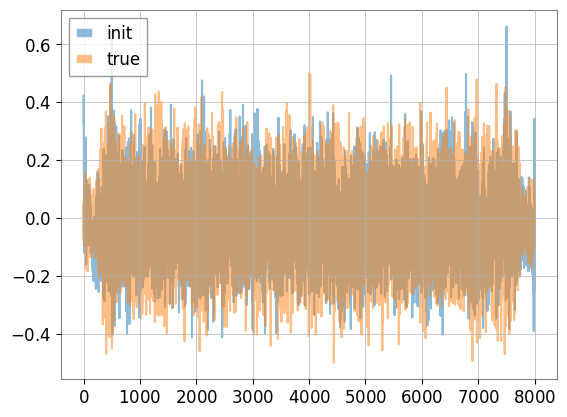

In [84]:
plt.plot(generated[0,0].detach().cpu(),label='init',alpha=0.5)
plt.plot(batch[0,0].detach().cpu(),label='true',alpha=0.5)
#plt.plot(batch[0,1].detach().cpu(),label='aux 1')
#plt.plot(batch[0,2].detach().cpu(),label='aux 2')
plt.legend()

In [85]:
# loss function, learning rate, and optimiser

l2_loss = nn.MSELoss() #this is l2!!!
l1_loss = nn.L1Loss()  #this is L1!!!
loss=l1_loss#LogCoshLoss()
lr=0.001

G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr )

In [86]:
save_checkpoint='/kaggle/working/generator_unet_weights_test.checkpoint_epoch_{}.pth'
n_epochs=20

In [87]:
loss_plot, val_loss_plot,acc_plot, val_acc_plot=train_decoder(n_epochs,generator,loss,G_optimizer,dataloader,test_dataloader,calculate_iou_2d,save_checkpoint)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 1 loss: 0.09173646569252014 val loss: 0.08833296597003937
epoch: 2 loss: 0.0875759944319725 val loss: 0.08606468886137009
epoch: 3 loss: 0.08581969141960144 val loss: 0.08591719716787338
epoch: 4 loss: 0.08527970314025879 val loss: 0.08481393754482269
epoch: 5 loss: 0.0847092717885971 val loss: 0.08527254313230515
epoch: 6 loss: 0.0843399167060852 val loss: 0.08444292843341827
epoch: 7 loss: 0.0841272845864296 val loss: 0.08405940234661102
epoch: 8 loss: 0.08391772955656052 val loss: 0.0838073119521141
epoch: 9 loss: 0.0837319865822792 val loss: 0.08392327278852463
epoch: 10 loss: 0.08356010913848877 val loss: 0.08358301222324371
epoch: 11 loss: 0.08329357951879501 val loss: 0.08352242410182953
epoch: 12 loss: 0.0830896645784378 val loss: 0.08301567286252975
epoch: 13 loss: 0.0828741043806076 val loss: 0.0828440859913826
epoch: 14 loss: 0.08273530006408691 val loss: 0.08290562033653259
epoch: 15 loss: 0.08268370479345322 val loss: 0.0828731581568718
epoch: 16 loss: 0.08246275782

In [88]:
#save model in native PyTorch format (.pth or .pt)
torch.save(generator.state_dict(), '/kaggle/working/generator_unet_weights_test.pth')
print('Model saved')

Model saved


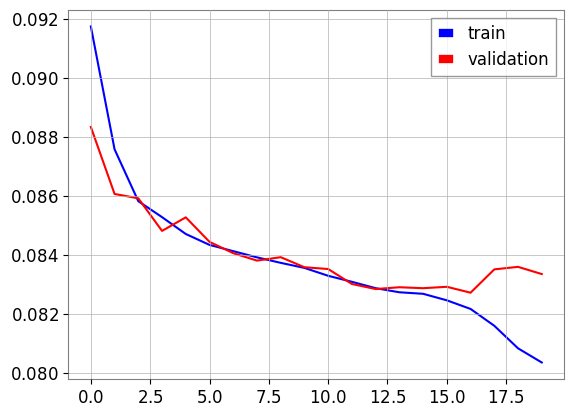

In [89]:
# Plotting the loss
import matplotlib.pyplot as plt
plt.plot(loss_plot,color='b',label='train')
plt.plot(val_loss_plot,color='r',label='validation')
#plt.title('L1 loss vs epoch - 100 Data Standardised and resampled')
plt.legend()
plt.savefig('lc.pdf')
plt.show()

# Plotting The Syntetic Signals

### Load Checkpoint

In [90]:
'''# Define the path to your checkpoint file
checkpoint_path = '/home/jovyan/checkpoints/checkpoint_epoch_best.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model state from the checkpoint
generator.load_state_dict(checkpoint['model_state_dict'])'''

"# Define the path to your checkpoint file\ncheckpoint_path = '/home/jovyan/checkpoints/checkpoint_epoch_best.pth'\n\n# Load the checkpoint\ncheckpoint = torch.load(checkpoint_path)\n\n# Load the model state from the checkpoint\ngenerator.load_state_dict(checkpoint['model_state_dict'])"

In [91]:
#Generate data for first batch
for batch in test_dataloader:
    generated=generate_data(generator,batch)
    break

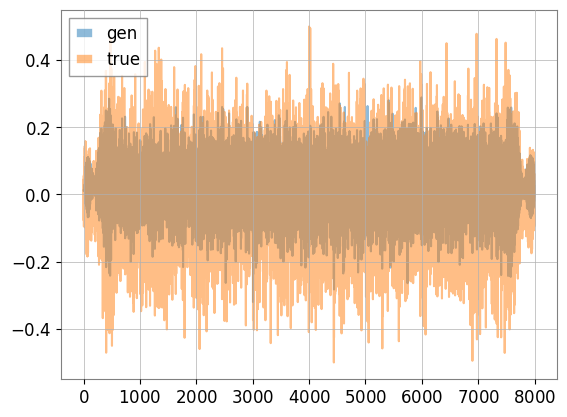

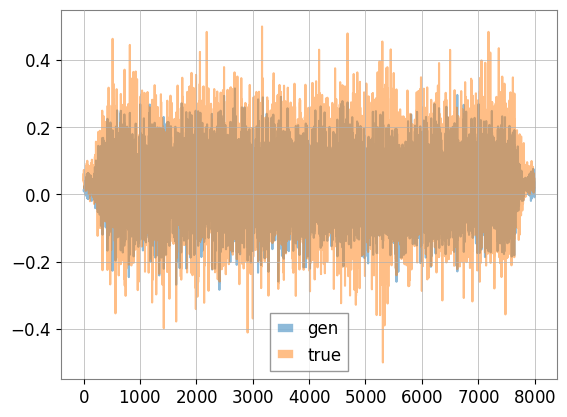

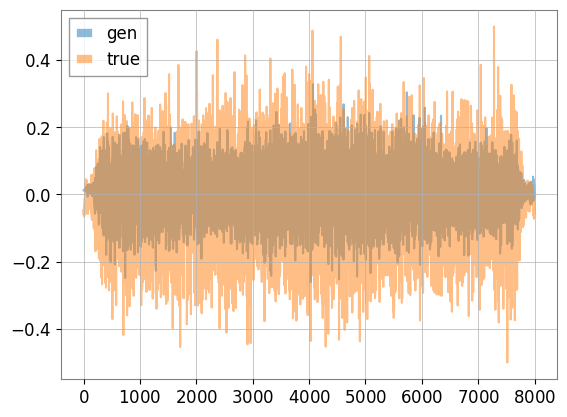

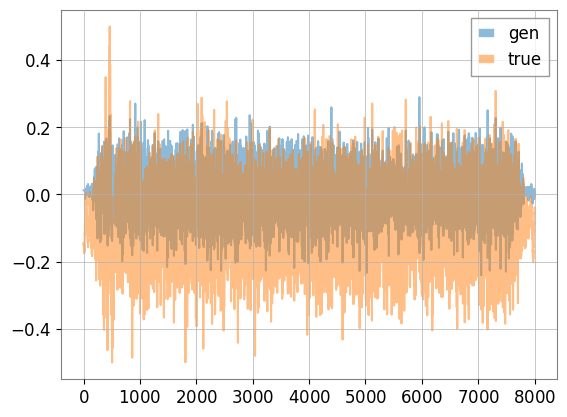

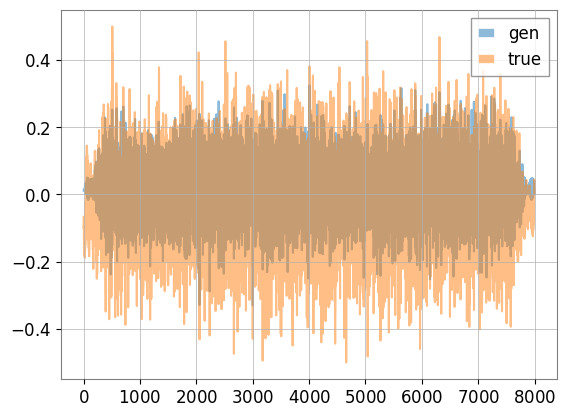

In [92]:
for i in range(5):
    plt.plot(generated[i,0].detach().cpu(),label='gen',alpha=0.5)
    plt.plot(batch[i,0].detach().cpu(),label='true',alpha=0.5)
    plt.legend()
    plt.show()

### **Plotting Spectrograms**

In [93]:
# utils function to calculate IOU during inference
def calculate_iou_2d_inference(spec_generated, spec_target, threshold):
    """
    Calculate Intersection over Union (IoU) in the 2D plane at the specified intensity threshold.

    Parameters:
    - generated: List of time series representing the generated spectrograms
    - target: List of time series representing the target spectrograms
    - threshold: Intensity threshold for determining the binary masks

    Returns:
    - IoU: Intersection over Union
    """
    # Extract spectrogram values from time series


    # Create binary masks based on the intensity threshold
    mask1 = spec_generated >= threshold 
    mask2 = spec_target >= threshold 

    # Calculate the intersection and union of the binary masks
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2) 

    # Calculate Intersection over Union (IoU)
    iou= np.sum(intersection) / np.sum(union) 

    return iou


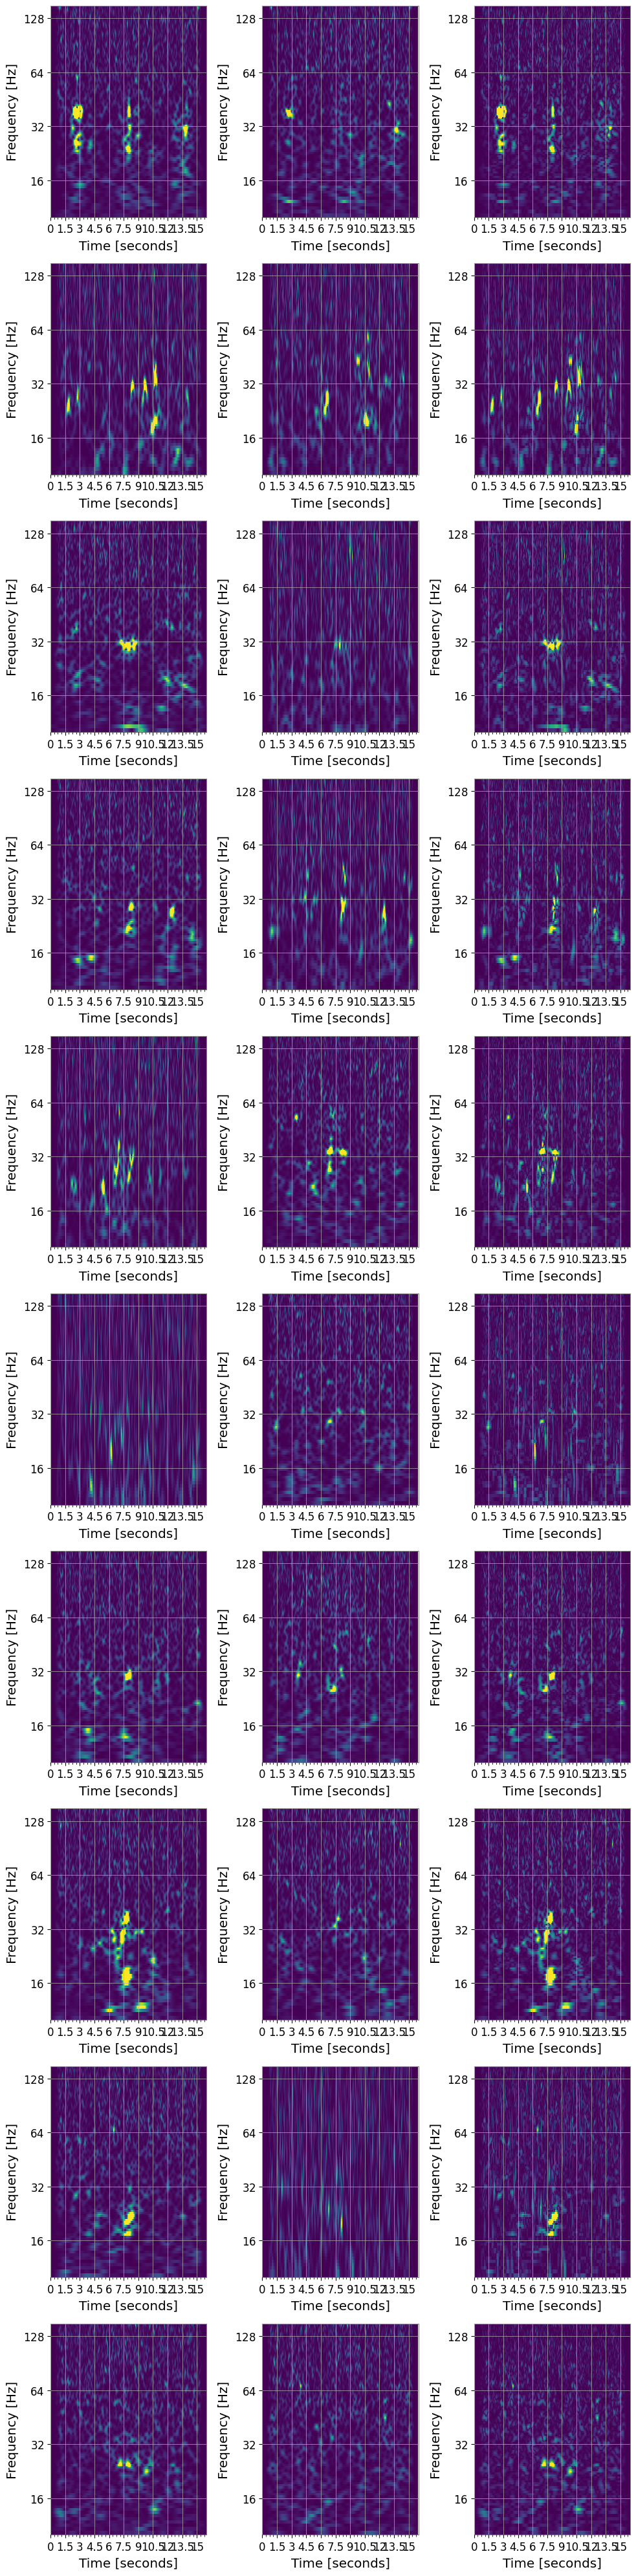

In [94]:
# Create a single figure for all subplots
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=[10, 4 * 10])
iou_list=[]
for i in range(10):
    real_signal_ts = TimeSeries(signal_data_test[i][0].cpu().numpy())
    real_signal_ts.dt = 1.0 / 500.0
    #real_signal_ts.whiten()
    real_qspecgram = real_signal_ts.q_transform(frange=(10, 150))

    
    
    tmsrs = TimeSeries(generated[i][0].cpu().numpy())
    tmsrs.dt = 1.0 / 500.0
    #tmsrs = tmsrs.whiten()
    qspecgram = tmsrs.q_transform(frange=(10, 150))

    #calculate IOU between real and generated spectrograms
    iou=calculate_iou_2d_inference(qspecgram, real_qspecgram, 20)
    iou_list.append(iou)
    
    # Plot on the specified subplot
    axes[i, 0].imshow(real_qspecgram, cmap='viridis', aspect='auto', origin='lower', vmin=0, vmax=25)
    axes[i, 1].imshow(qspecgram, cmap='viridis', aspect='auto', origin='lower', vmin=0, vmax=25)
    axes[i, 2].imshow(abs(real_qspecgram-qspecgram), cmap='viridis', aspect='auto', origin='lower', vmin=0, vmax=25)

    axes[i, 0].set_xscale('seconds')
    axes[i, 0].set_yscale('log', base=2)
    axes[i, 0].set_ylim(10, 150)
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 0].set_xlabel('Time [seconds]')

    axes[i, 1].set_xscale('seconds')
    axes[i, 1].set_yscale('log', base=2)
    axes[i, 1].set_ylim(10, 150)
    axes[i, 1].set_ylabel('Frequency [Hz]')
    axes[i, 1].set_xlabel('Time [seconds]')
    
    axes[i, 2].set_xscale('seconds')
    axes[i, 2].set_yscale('log', base=2)
    axes[i, 2].set_ylim(10, 150)
    axes[i, 2].set_ylabel('Frequency [Hz]')
    axes[i, 2].set_xlabel('Time [seconds]')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the entire figure as a single PNG file
plt.savefig('fake_v_real_decoder_all.pdf')
plt.show()

In [95]:
#IOU between real and generated spectrograms
iou_list

[0.1963109354413702,
 0.07238605898123325,
 0.05958132045088567,
 0.24623115577889448,
 0.12477064220183487,
 0.0,
 0.030864197530864196,
 0.03873744619799139,
 0.039119804400977995,
 0.05813953488372093]

### **Plotting generated signals**

In [ ]:
fig, ax = plt.subplots(nrows=generated.shape[0], ncols=2, figsize=[80, generated.shape[0] * 20])

for i in range(generated.shape[0]):
    generated_signal_ts=TimeSeries(generated[i][0].cpu().numpy())
    generated_signal_ts.dt = 1.0 / 500.0  #Note: if not using resampled (or with different resampling) data you must change 1.0/500.0 by hand
    
    # generated_signal_ts_gpt=TimeSeries(generated_chatgpt[i][0].cpu().numpy())
    # generated_signal_ts_gpt.dt = 1.0 / 4096.0 
    
    
    real_signal_ts=TimeSeries(signal_data_test[i][0].cpu().numpy())
    real_signal_ts.dt = 1.0 / 500.0 #Note: if not using resampled (or with different resampling) data you must change 1.0/500.0 by hand
    
    ax[i,0].plot(real_signal_ts,color='b',label='Real' )
    ax[i,1].plot(generated_signal_ts, color='r',label='Generated')
    
    
plt.show()